## <span style='background :#3FBFBF' >*******************  IMPORTS *******************</span>  

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

df_train = pd.read_csv('../datasets/compdata/comp_cleaned_train_data.csv',keep_default_na=False)
df_test = pd.read_csv('../datasets/compdata/comp_cleaned_test_data.csv')


## <span style='background :#3FBFBF' >*******************  DATA SETUP *******************</span>  

In [2]:
pd.options.display.max_columns = 999  # Allos us to display all columns
pd.options.display.max_rows = 999  # Allos us to display all columns

df_train.columns = df_train.columns.str.lower() # column names to lower case
df_test.columns = df_test.columns.str.lower() # column names to lower case

## <span style='background :#3FBFBF' >*******************  FIRST LOOK *******************</span>  

In [3]:
df_train.shape, df_test.shape  # The differnece in # of columns should be neighborhood columns

((2051, 229), (878, 220))

In [4]:
# Double check every thing for null values

for col in df_train:                   # Starting with the df_train data
    x = df_train[col].isnull().sum()   # Check each column for nulls
    if x > 0: 
        print(f'df_train{[col]} : {x} null vals.')   # Print the column info if there are null values

for col in df_test:                   # Starting with the df_test data
    y = df_test[col].isnull().sum()   # Check each column for nulls
    if y > 0: 
        print(f'df_train{[col]} : {x} null vals.')   # Print the column info if there are null values        
        
      

df_train['mas vnr area'] : 0 null vals.


In [5]:
# Check for object type columns
obj_cols = df_train.dtypes[df_train.dtypes == 'object'].index
obj_cols

Index(['mas vnr area'], dtype='object')

In [6]:
# Check for object type columns
obj_cols = df_test.dtypes[df_test.dtypes == 'object'].index
obj_cols

Index([], dtype='object')

With no Nulls, and no object (string) data, we can look at distributions, correlations to the target, and outliers.
### First, we're going to look at the correlations to saleprice.
There is a lot of data here, and a limited amount of time, so we want to 
focus our efforts on the data points that we're most likely to include in 
any potention models.


In [7]:
df_train.corr()[['saleprice']].sort_values(['saleprice'], 
                                           ascending=False
                                          ).head(10)                # gives you everything corelated to apps

,saleprice
saleprice,1.000000
overall qual,0.800207
exter qual,0.712146
gr liv area,0.697038
kitchen qual,0.692336
garage area,0.649897
garage cars,0.647781
total bsmt sf,0.629303
1st flr sf,0.618486
bsmt qual_ex,0.586497


This is going to be a SUPER long list with over 170 features to consider, and strong neagtive and positive correlations to consider.
To make this task easier, we're going to find the absolute values of our correlations, and then sort highest to lowest.
We don't care if the correlation is positive or negative, we really just care about how close it is to 1.


In [8]:
corrs = df_train.corr()[['saleprice']].abs().sort_values(['saleprice'], ascending=False)  #.index.tolist() 
# gives you every feature and its corelation to salesprice in terms of absolute value, both positive and negative
corrs.rename(columns={'saleprice':'corr_1'},inplace=True)
# calling the column corr_1 because we're going to try to deal with outliers and then retake the correlation 

corrs#.head(11)
#with help from https://www.marsja.se/renaming-columns-in-pandas-dataframe/#:~:text=So%20how%20do%20you%20change,columns%20%3D%20list_of_new_names%20.


,corr_1
saleprice,1.000000
overall qual,0.800207
exter qual,0.712146
gr liv area,0.697038
kitchen qual,0.692336
garage area,0.649897
garage cars,0.647781
total bsmt sf,0.629303
1st flr sf,0.618486
bsmt qual_ex,0.586497


In [9]:
## df_train.corr()[['saleprice']].abs().sort_values(['saleprice'], ascending=False).index.tolist() 

### Next, we're just going to plot those correlations and look for potential outliers


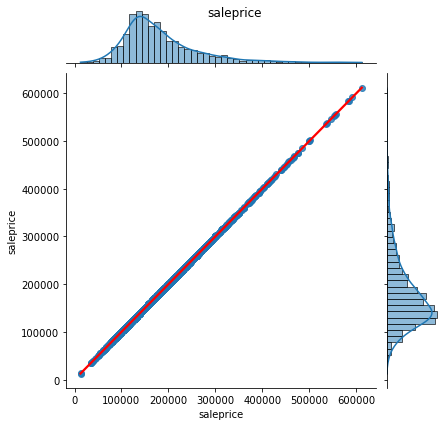

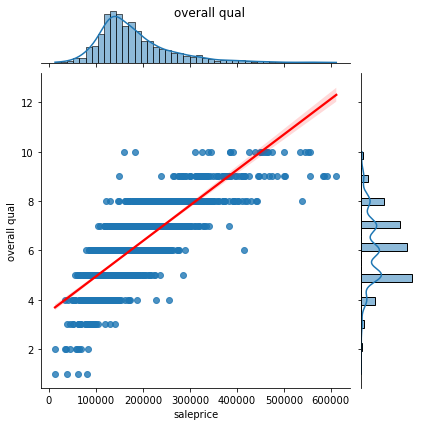

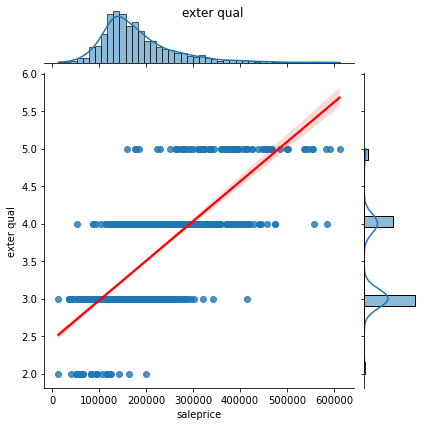

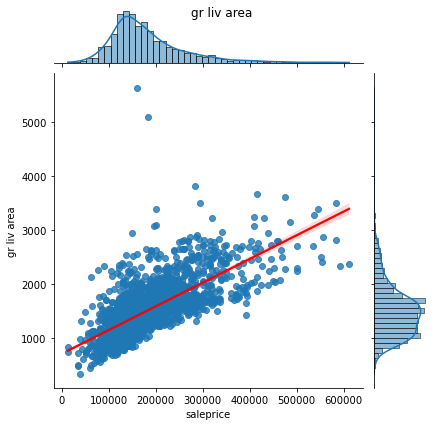

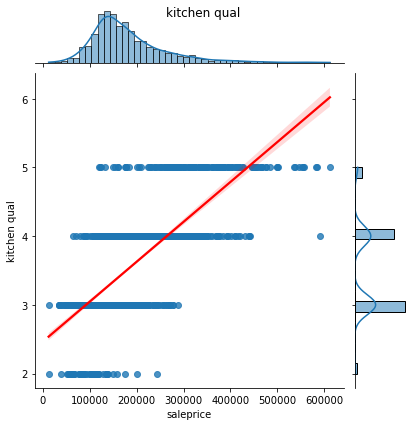

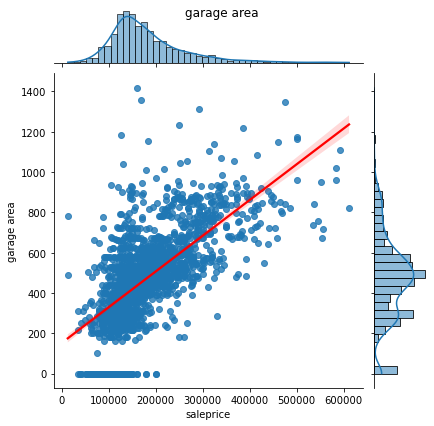

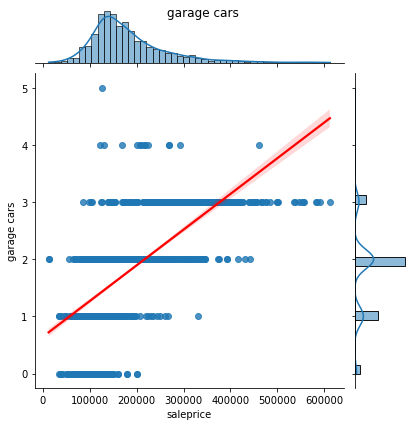

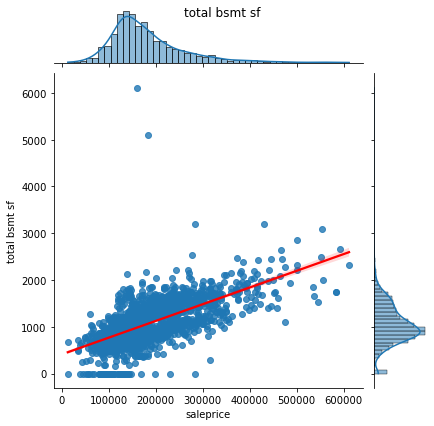

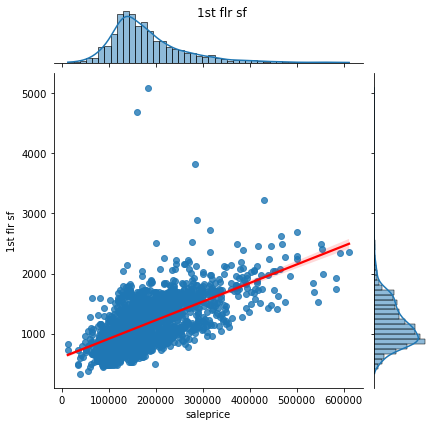

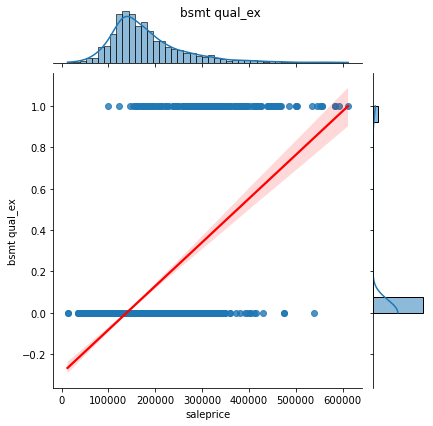

In [10]:
for feature in corrs.head(10).iterrows():
    #print(feature[0])
    #sns.jointplot(data=df_train, x="saleprice", y=feature[0], kind="reg", color='r')
    p = sns.jointplot(data=df_train, x="saleprice", y=feature[0], kind='reg', 
              line_kws={"color": "red"});
    p.fig.suptitle(feature[0])

# with help from 
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot


Based on the charts above, it looks like there maybe some outliers in:

1. Garage Area
2. Garage Cars
3. Total Bsmt Sq Ft
4. 1st Flr Sq Ft

But within these other features, some odd balls also stick out

1. Overall Qual : Looks like a 10 with a low sales price
2. Overall Qual Looks like a 6 with a high sales price
3. Ext Qual: Looks like some 3s and 4s with high sales prices
4. Gr Liv Area: Some with high sq ft but low sales price
5. Kitchen Qual: One 4 with a high sales price
6. Bsmt Qual: Looks like some 3s and 4s with high sales prices

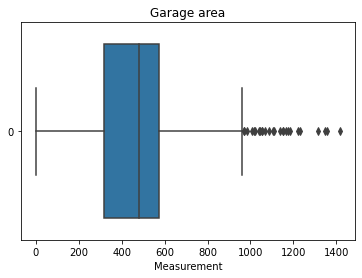

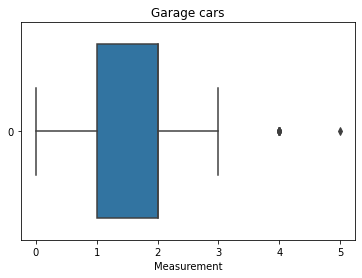

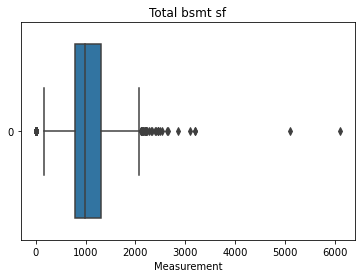

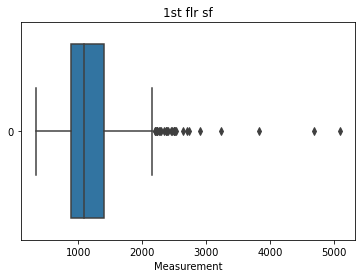

In [11]:
outliers = ['garage area','garage cars','total bsmt sf','1st flr sf']   # put outliers in a list

for i,feature in enumerate(outliers):   # for each item in the list                    
    plt.figure(i)                       # creat the new fig
    sns.boxplot(data=df_train[feature], # create the plot
            orient='h')
    plt.title(feature.capitalize())     # set the title
    plt.xlabel('Measurement');          # set the lable

# with help from https://stackoverflow.com/questions/41325160/seaborn-plots-in-a-loop

Based on the charts above, garage cars has obvious outliers, total basement sq ft has a bunch but 5000 and 6000 appear to be extremes.  1st flr sf also has some extremes over about 4500.  Garage area has plenty of outliers but nothing as obviously extreme as the other three. Let's look at those three features first.  For garage cars, we want to see anything more than 3. For total basement sq ft, we want to see anything more than 4500. For 1st flr sf, we want to see anything over 3500.

In [12]:
def find_outliers(col):
    q1 = np.percentile(df_train[col], 25)  # Find the first quartile
    q3 = np.percentile(df_train[col], 75)  # Find the third quartile
    iqr = q3 - q1                          # Calculate the IQR
             # The normal lower limit is Q1 – (1.5 * IQR)
             # THe normal upper limit as Q3 + (1.5 * IQR)
    lowerbound = q1 - 1.5 * iqr            # lower bound 
    upperbound = q3 + 1.5 * iqr            # Upper bound 
    
    return f'For {col}: below {lowerbound} or above {upperbound} is an outlier.'

for feature in corrs.head(10).iterrows():
    print(find_outliers(feature[0]))

For saleprice: below 3562.5 or above 340262.5 is an outlier.
For overall qual: below 2.0 or above 10.0 is an outlier.
For exter qual: below 1.5 or above 5.5 is an outlier.
For gr liv area: below 229.75 or above 2627.75 is an outlier.
For kitchen qual: below 1.5 or above 5.5 is an outlier.
For garage area: below -66.5 or above 961.5 is an outlier.
For garage cars: below -0.5 or above 3.5 is an outlier.
For total bsmt sf: below 4.75 or above 2106.75 is an outlier.
For 1st flr sf: below 91.25 or above 2193.25 is an outlier.
For bsmt qual_ex: below 0.0 or above 0.0 is an outlier.


In [13]:
df_train.loc[df_train['garage cars'] > 3.5]
# this looks like a large number of outliers,  we're going to stick with removing just those over 4

,1st flr sf,2nd flr sf,3ssn porch,bedroom abvgr,bsmt full bath,bsmt half bath,bsmt unf sf,bsmtfin sf 1,bsmtfin sf 2,central air,condition 1,condition 2,enclosed porch,exter cond,exter qual,exterior 1st,exterior 2nd,fireplaces,full bath,functional,garage area,garage cars,garage yr blt,gr liv area,half bath,heating,heating qc,id,kitchen abvgr,kitchen qual,land slope,lot area,lot frontage,lot shape,low qual fin sf,ms subclass,mas vnr area,misc val,mo sold,open porch sf,overall cond,overall qual,paved drive,pool area,saleprice,screen porch,street,totrms abvgrd,total bsmt sf,utilities,wood deck sf,year built,year remod/add,yr sold,bsmt cond_ex,bsmt cond_fa,bsmt cond_gd,bsmt cond_na,bsmt cond_po,bsmt cond_ta,bsmt exposure_av,bsmt exposure_gd,bsmt exposure_mn,bsmt exposure_na,bsmt exposure_no,bsmt qual_ex,bsmt qual_fa,bsmt qual_gd,bsmt qual_na,bsmt qual_po,bsmt qual_ta,bsmtfin type 1_alq,bsmtfin type 1_blq,bsmtfin type 1_glq,bsmtfin type 1_lwq,bsmtfin type 1_na,bsmtfin type 1_rec,bsmtfin type 1_unf,bsmtfin type 2_alq,bsmtfin type 2_blq,bsmtfin type 2_glq,bsmtfin type 2_lwq,bsmtfin type 2_na,bsmtfin type 2_rec,bsmtfin type 2_unf,electrical_fusea,electrical_fusef,electrical_fusep,electrical_mix,electrical_sbrkr,fence_gdprv,fence_gdwo,fence_mnprv,fence_mnww,fence_na,fireplace qu_ex,fireplace qu_fa,fireplace qu_gd,fireplace qu_na,fireplace qu_po,fireplace qu_ta,garage cond_ex,garage cond_fa,garage cond_gd,garage cond_na,garage cond_po,garage cond_ta,garage finish_fin,garage finish_na,garage finish_rfn,garage finish_unf,garage qual_ex,garage qual_fa,garage qual_gd,garage qual_na,garage qual_po,garage qual_ta,garage type_2types,garage type_attchd,garage type_basment,garage type_builtin,garage type_carport,garage type_detchd,garage type_na,mas vnr type_brkcmn,mas vnr type_brkface,mas vnr type_na,mas vnr type_none,mas vnr type_stone,misc feature_elev,misc feature_gar2,misc feature_na,misc feature_othr,misc feature_shed,misc feature_tenc,pool qc_ex,pool qc_fa,pool qc_gd,pool qc_na,pool qc_ta,bldg type_1fam,bldg type_2fmcon,bldg type_duplex,bldg type_twnhs,bldg type_twnhse,conditions,exteriors,alley_grvl,alley_na,alley_pave,foundation_brktil,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,house style_1.5fin,house style_1.5unf,house style_1story,house style_2.5fin,house style_2.5unf,house style_2story,house style_sfoyer,house style_slvl,land contour_bnk,land contour_hls,land contour_low,land contour_lvl,lot config_corner,lot config_culdsac,lot config_fr2,lot config_fr3,lot config_inside,ms zoning_a (agr),ms zoning_c (all),ms zoning_fv,ms zoning_i (all),ms zoning_rh,ms zoning_rl,ms zoning_rm,neighborhood_blmngtn,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_npkvill,neighborhood_nwames,neighborhood_noridge,neighborhood_nridght,neighborhood_oldtown,neighborhood_swisu,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_timber,neighborhood_veenker,roof matl_clytile,roof matl_compshg,roof matl_membran,roof matl_tar&grv,roof matl_wdshake,roof matl_wdshngl,roof style_flat,roof style_gable,roof style_gambrel,roof style_hip,roof style_mansard,roof style_shed,sale type_cod,sale type_cwd,sale type_con,sale type_conld,sale type_conli,sale type_conlw,sale type_new,sale type_oth,sale type_wd
194,1338,1296,0,6,1.0,1.0,748.0,500.0,0.0,1,0,1,0,3,3,7,10,0,2,8,968.0,4.0,1969.0,2634,2,5,3,670,2,3,3,11643,91.000000,4,0,90,368.0,0,8,0,5,5,2,0,200000,0,1,12,1248.0,4,0,1969,1969,2009,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,17,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,

In [14]:
df_train.loc[df_train['total bsmt sf'] > 2100]
# This is a lot of outliers, we're going to stick with removing just those over 4500

,1st flr sf,2nd flr sf,3ssn porch,bedroom abvgr,bsmt full bath,bsmt half bath,bsmt unf sf,bsmtfin sf 1,bsmtfin sf 2,central air,condition 1,condition 2,enclosed porch,exter cond,exter qual,exterior 1st,exterior 2nd,fireplaces,full bath,functional,garage area,garage cars,garage yr blt,gr liv area,half bath,heating,heating qc,id,kitchen abvgr,kitchen qual,land slope,lot area,lot frontage,lot shape,low qual fin sf,ms subclass,mas vnr area,misc val,mo sold,open porch sf,overall cond,overall qual,paved drive,pool area,saleprice,screen porch,street,totrms abvgrd,total bsmt sf,utilities,wood deck sf,year built,year remod/add,yr sold,bsmt cond_ex,bsmt cond_fa,bsmt cond_gd,bsmt cond_na,bsmt cond_po,bsmt cond_ta,bsmt exposure_av,bsmt exposure_gd,bsmt exposure_mn,bsmt exposure_na,bsmt exposure_no,bsmt qual_ex,bsmt qual_fa,bsmt qual_gd,bsmt qual_na,bsmt qual_po,bsmt qual_ta,bsmtfin type 1_alq,bsmtfin type 1_blq,bsmtfin type 1_glq,bsmtfin type 1_lwq,bsmtfin type 1_na,bsmtfin type 1_rec,bsmtfin type 1_unf,bsmtfin type 2_alq,bsmtfin type 2_blq,bsmtfin type 2_glq,bsmtfin type 2_lwq,bsmtfin type 2_na,bsmtfin type 2_rec,bsmtfin type 2_unf,electrical_fusea,electrical_fusef,electrical_fusep,electrical_mix,electrical_sbrkr,fence_gdprv,fence_gdwo,fence_mnprv,fence_mnww,fence_na,fireplace qu_ex,fireplace qu_fa,fireplace qu_gd,fireplace qu_na,fireplace qu_po,fireplace qu_ta,garage cond_ex,garage cond_fa,garage cond_gd,garage cond_na,garage cond_po,garage cond_ta,garage finish_fin,garage finish_na,garage finish_rfn,garage finish_unf,garage qual_ex,garage qual_fa,garage qual_gd,garage qual_na,garage qual_po,garage qual_ta,garage type_2types,garage type_attchd,garage type_basment,garage type_builtin,garage type_carport,garage type_detchd,garage type_na,mas vnr type_brkcmn,mas vnr type_brkface,mas vnr type_na,mas vnr type_none,mas vnr type_stone,misc feature_elev,misc feature_gar2,misc feature_na,misc feature_othr,misc feature_shed,misc feature_tenc,pool qc_ex,pool qc_fa,pool qc_gd,pool qc_na,pool qc_ta,bldg type_1fam,bldg type_2fmcon,bldg type_duplex,bldg type_twnhs,bldg type_twnhse,conditions,exteriors,alley_grvl,alley_na,alley_pave,foundation_brktil,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,house style_1.5fin,house style_1.5unf,house style_1story,house style_2.5fin,house style_2.5unf,house style_2story,house style_sfoyer,house style_slvl,land contour_bnk,land contour_hls,land contour_low,land contour_lvl,lot config_corner,lot config_culdsac,lot config_fr2,lot config_fr3,lot config_inside,ms zoning_a (agr),ms zoning_c (all),ms zoning_fv,ms zoning_i (all),ms zoning_rh,ms zoning_rl,ms zoning_rm,neighborhood_blmngtn,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_npkvill,neighborhood_nwames,neighborhood_noridge,neighborhood_nridght,neighborhood_oldtown,neighborhood_swisu,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_timber,neighborhood_veenker,roof matl_clytile,roof matl_compshg,roof matl_membran,roof matl_tar&grv,roof matl_wdshake,roof matl_wdshngl,roof style_flat,roof style_gable,roof style_gambrel,roof style_hip,roof style_mansard,roof style_shed,sale type_cod,sale type_cwd,sale type_con,sale type_conld,sale type_conli,sale type_conlw,sale type_new,sale type_oth,sale type_wd
30,2524,0,0,4,1.0,0.0,1420.0,1104.0,0.0,1,2,1,0,3,4,12,13,1,2,8,542.0,2.0,1981.0,2524,1,5,3,380,1,4,3,9600,80.00000,4,0,20,0.0,0,7,120,5,8,2,0,278000,0,1,9,2524.0,4,474,1981,1981,2009,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,3,25,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,

In [15]:
df_train.loc[df_train['1st flr sf'] > 2193]
# Also a lot of outliers, going to stick with 3500

,1st flr sf,2nd flr sf,3ssn porch,bedroom abvgr,bsmt full bath,bsmt half bath,bsmt unf sf,bsmtfin sf 1,bsmtfin sf 2,central air,condition 1,condition 2,enclosed porch,exter cond,exter qual,exterior 1st,exterior 2nd,fireplaces,full bath,functional,garage area,garage cars,garage yr blt,gr liv area,half bath,heating,heating qc,id,kitchen abvgr,kitchen qual,land slope,lot area,lot frontage,lot shape,low qual fin sf,ms subclass,mas vnr area,misc val,mo sold,open porch sf,overall cond,overall qual,paved drive,pool area,saleprice,screen porch,street,totrms abvgrd,total bsmt sf,utilities,wood deck sf,year built,year remod/add,yr sold,bsmt cond_ex,bsmt cond_fa,bsmt cond_gd,bsmt cond_na,bsmt cond_po,bsmt cond_ta,bsmt exposure_av,bsmt exposure_gd,bsmt exposure_mn,bsmt exposure_na,bsmt exposure_no,bsmt qual_ex,bsmt qual_fa,bsmt qual_gd,bsmt qual_na,bsmt qual_po,bsmt qual_ta,bsmtfin type 1_alq,bsmtfin type 1_blq,bsmtfin type 1_glq,bsmtfin type 1_lwq,bsmtfin type 1_na,bsmtfin type 1_rec,bsmtfin type 1_unf,bsmtfin type 2_alq,bsmtfin type 2_blq,bsmtfin type 2_glq,bsmtfin type 2_lwq,bsmtfin type 2_na,bsmtfin type 2_rec,bsmtfin type 2_unf,electrical_fusea,electrical_fusef,electrical_fusep,electrical_mix,electrical_sbrkr,fence_gdprv,fence_gdwo,fence_mnprv,fence_mnww,fence_na,fireplace qu_ex,fireplace qu_fa,fireplace qu_gd,fireplace qu_na,fireplace qu_po,fireplace qu_ta,garage cond_ex,garage cond_fa,garage cond_gd,garage cond_na,garage cond_po,garage cond_ta,garage finish_fin,garage finish_na,garage finish_rfn,garage finish_unf,garage qual_ex,garage qual_fa,garage qual_gd,garage qual_na,garage qual_po,garage qual_ta,garage type_2types,garage type_attchd,garage type_basment,garage type_builtin,garage type_carport,garage type_detchd,garage type_na,mas vnr type_brkcmn,mas vnr type_brkface,mas vnr type_na,mas vnr type_none,mas vnr type_stone,misc feature_elev,misc feature_gar2,misc feature_na,misc feature_othr,misc feature_shed,misc feature_tenc,pool qc_ex,pool qc_fa,pool qc_gd,pool qc_na,pool qc_ta,bldg type_1fam,bldg type_2fmcon,bldg type_duplex,bldg type_twnhs,bldg type_twnhse,conditions,exteriors,alley_grvl,alley_na,alley_pave,foundation_brktil,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,house style_1.5fin,house style_1.5unf,house style_1story,house style_2.5fin,house style_2.5unf,house style_2story,house style_sfoyer,house style_slvl,land contour_bnk,land contour_hls,land contour_low,land contour_lvl,lot config_corner,lot config_culdsac,lot config_fr2,lot config_fr3,lot config_inside,ms zoning_a (agr),ms zoning_c (all),ms zoning_fv,ms zoning_i (all),ms zoning_rh,ms zoning_rl,ms zoning_rm,neighborhood_blmngtn,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_npkvill,neighborhood_nwames,neighborhood_noridge,neighborhood_nridght,neighborhood_oldtown,neighborhood_swisu,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_timber,neighborhood_veenker,roof matl_clytile,roof matl_compshg,roof matl_membran,roof matl_tar&grv,roof matl_wdshake,roof matl_wdshngl,roof style_flat,roof style_gable,roof style_gambrel,roof style_hip,roof style_mansard,roof style_shed,sale type_cod,sale type_cwd,sale type_con,sale type_conld,sale type_conli,sale type_conlw,sale type_new,sale type_oth,sale type_wd
30,2524,0,0,4,1.0,0.0,1420.0,1104.0,0.0,1,2,1,0,3,4,12,13,1,2,8,542.0,2.0,1981.0,2524,1,5,3,380,1,4,3,9600,80.000000,4,0,20,0.0,0,7,120,5,8,2,0,278000,0,1,9,2524.0,4,474,1981,1981,2009,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,3,25,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0

In [16]:
df_train.drop(df_train.index[df_train['garage cars'] > 4], inplace=True)

In [17]:
df_train.drop(df_train.index[df_train['total bsmt sf'] > 4500], inplace=True)

In [18]:
df_train.drop(df_train.index[df_train['1st flr sf'] > 3500], inplace=True)

In [19]:
df_train.corr()[['saleprice']].sort_values(['saleprice'], 
                                           ascending=False
                                          ).head(10)                # gives you everything corelated to apps

,saleprice
saleprice,1.000000
overall qual,0.804360
gr liv area,0.720682
exter qual,0.715800
kitchen qual,0.693929
total bsmt sf,0.668048
garage area,0.657966
garage cars,0.652663
1st flr sf,0.651947
bsmt qual_ex,0.590245


In [20]:
df_train.columns = df_train.columns.str.lower() # column names to lower case


df_train.to_csv('../datasets/compdata/comp_cleaned_train_to_model.csv', index=False)